In [1]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from calc import sqrt_p_to_tick


def plot(
    ticks_a: list[int],
    ticks_b: list[int],
    liqs_a: list[int],
    liqs_b: list[int],
    tick_a: int,
    tick_b: int,
    sa: float,
    sb: float,
):
    plt.figure(figsize=(10, 4))

    # TODO: generalize?
    # Show price on X axis
    # plt.gca().xaxis.set_major_formatter(
    #     mticker.FuncFormatter(lambda t, _: f"{int(1e12/tick_to_p(t)):,}")
    # )
    plt.gca().xaxis.set_major_formatter(
        mticker.FuncFormatter(lambda t, _: f"{int(t):,}")
    )

    plt.step(ticks_a, liqs_a, where="post", linewidth=2, label="Pool A")
    plt.step(ticks_b, liqs_b, where="post", linewidth=2, label="Pool B")

    plt.axvline(tick_a, linewidth=1.5, color="tab:pink", label=f"tick a = {tick_a}")
    plt.axvline(tick_b, linewidth=1.5, color="tab:pink", label=f"tick b = {tick_b}")
    plt.axvline(
        sqrt_p_to_tick(sa),
        linewidth=1.5,
        color="tab:purple",
        label=f"tick a after swap = {sqrt_p_to_tick(sa)}",
    )
    plt.axvline(
        sqrt_p_to_tick(sb),
        linewidth=1.5,
        color="tab:purple",
        label=f"tick b after swap = {sqrt_p_to_tick(sb)}",
    )

    plt.xlabel("Tick")
    plt.ylabel("Liquidity")
    plt.title("Uniswap pools")

    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

tick a: 199474 tick b: 200084
dya: 4.536038165376608e+20 dyb: 4.6614169922538006e+20 sa: 22059.528815099788 sb: 22061.618174070252
dyb - dya: 1.2537882687719277e+19


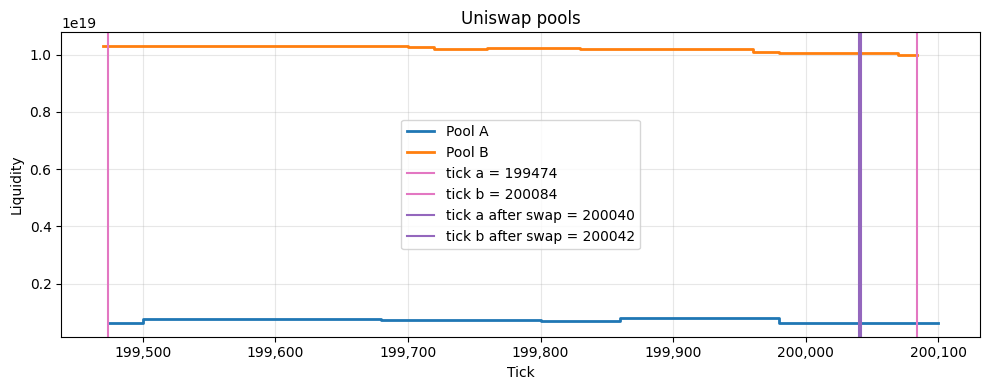

In [2]:
from calc import calc_dya
from data import get, build, map_sqrt

# Simulation using real data
fee_a = 0.0005
fee_b = 0.003

ticks_a, liqs_a, pool_a = build(get("tmp/pool_a.json"), True)
ticks_b, liqs_b, pool_b = build(get("tmp/pool_b.json"), False)

# First tick lo
tick_a = pool_a[0][0]
# First tick hi
tick_b = pool_b[0][1]

print("tick a:", tick_a, "tick b:", tick_b)

(dya, dyb, sa, sb) = calc_dya(
    map_sqrt(pool_a),
    map_sqrt(pool_b),
    fee_a,
    fee_b,
)
print("dya:", dya, "dyb:", dyb, "sa:", sa, "sb:", sb)
print("dyb - dya:", dyb - dya)

plot(ticks_a, ticks_b, liqs_a, liqs_b, tick_a, tick_b, sa, sb)

sim dya: 28.808018813397727 dyb: 29.161761916466354 sa: 0.9953786301027256 sb: 0.997124378133832
dyb - dya: 0.3537431030686271


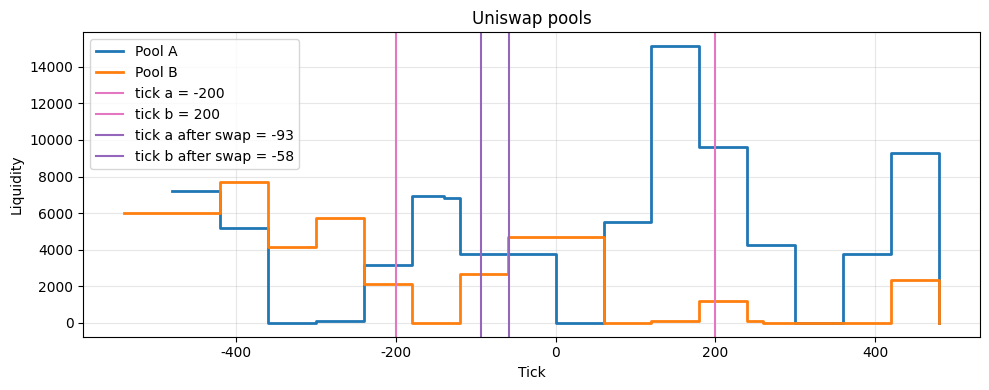

In [5]:
# Simulation using random data

import math
import random
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
from calc import tick_to_sqrt_p

# Fee Tier | Typical Tick Spacing
# -------- | --------------------
# 0.05%    | 1
# 0.3%     | 60
# 1%       | 200
# 10%      | 2000

TICK_SPACING_A = 60
TICK_SPACING_B = 60
FEE_A = 0.003
FEE_B = 0.0005
TICK_A = -200
TICK_B = 200


def random_positions(
    n_positions,
    tick_min=-500,
    tick_max=500,
    tick_spacing=10,
    min_width=20,
    max_width=200,
    min_liquidity=0,
    max_liquidity=6000,
):
    positions = []
    # snap tick_min and tick_max to tick spacing
    tick_min = (tick_min // tick_spacing) * tick_spacing
    tick_max = (tick_max // tick_spacing) * tick_spacing
    for _ in range(n_positions):
        # generate lower tick as multiple of tick_spacing
        lower = (
            random.randint(
                tick_min // tick_spacing, (tick_max - min_width) // tick_spacing
            )
            * tick_spacing
        )
        # random width in ticks, then snap upper
        width = random.randint(min_width, max_width)
        upper = lower + width
        # snap upper to tick spacing
        upper = ((upper + tick_spacing - 1) // tick_spacing) * tick_spacing
        if upper > tick_max:
            upper = tick_max
        liquidity = random.randint(min_liquidity, max_liquidity)
        positions.append((lower, upper, liquidity))
    return positions


def build_liq(positions):
    liq_net = defaultdict(float)
    for lower, upper, L in positions:
        liq_net[lower] += L
        liq_net[upper] -= L
    ticks = np.array(sorted(liq_net.keys()))
    delta = np.array([liq_net[t] for t in ticks])
    liqs = np.cumsum(delta)
    # [(lower tick, upper tick, liquidity)]
    pool = []
    for i in range(len(ticks) - 1):
        if liqs[i] == 0:
            continue
        pool.append((ticks[i], ticks[i + 1], liqs[i]))
    return ticks, liqs, pool


def prep(pool, tick, up):
    # Check
    t = -math.inf
    for lo, hi, L in pool:
        assert t <= lo < hi
        t = lo
    # Slice
    s = []
    if up:
        assert any(lo <= tick <= hi for lo, hi, L in pool)
        s = [(lo, hi, L) for lo, hi, L in pool if tick < hi]
        assert len(s) > 0
        # print(up, s)
        (lo, hi, L) = s[0]
        assert lo <= tick
        s[0] = (tick, hi, L)
    else:
        assert any(lo <= tick <= hi for lo, hi, L in pool)
        s = [(lo, hi, L) for lo, hi, L in pool if lo < tick]
        assert len(s) > 0
        # print(up, s)
        (lo, hi, L) = s[-1]
        assert hi >= tick
        s[-1] = (lo, tick, L)
        s.reverse()
    # Map
    return [
        (tick_to_sqrt_p(tick_lo), tick_to_sqrt_p(tick_hi), L)
        for tick_lo, tick_hi, L in s
    ]


def prep(pool, tick, up):
    # Slice
    s = []
    if up:
        assert any(lo <= tick <= hi for lo, hi, L in pool)
        s = [(lo, hi, L) for lo, hi, L in pool if tick < hi]
        assert len(s) > 0
        # print(up, s)
        (lo, hi, L) = s[0]
        assert lo <= tick
        s[0] = (tick, hi, L)
    else:
        assert any(lo <= tick <= hi for lo, hi, L in pool)
        s = [(lo, hi, L) for lo, hi, L in pool if lo < tick]
        assert len(s) > 0
        # print(up, s)
        (lo, hi, L) = s[-1]
        assert hi >= tick
        s[-1] = (lo, tick, L)
        s.reverse()
    # Map
    return [
        (tick_to_sqrt_p(tick_lo), tick_to_sqrt_p(tick_hi), L)
        for tick_lo, tick_hi, L in s
    ]

def round_tick(tick, tick_spacing):
    return (tick // tick_spacing) * tick_spacing

pool_a_positions = random_positions(n_positions=10, tick_spacing=TICK_SPACING_A)
pool_a_positions.append(
    (
        round_tick(TICK_A - TICK_SPACING_A, TICK_SPACING_A),
        round(TICK_A + TICK_SPACING_A, TICK_SPACING_A),
        100,
    )
)
pool_b_positions = random_positions(n_positions=10, tick_spacing=TICK_SPACING_B)
pool_b_positions.append(
    (
        round_tick(TICK_B - TICK_SPACING_B, TICK_SPACING_B),
        round(TICK_B + TICK_SPACING_B, TICK_SPACING_B),
        100,
    )
)

ticks_a, liqs_a, pool_a = build_liq(pool_a_positions)
ticks_b, liqs_b, pool_b = build_liq(pool_b_positions)

pool_a = prep(pool_a, TICK_A, True)
pool_b = prep(pool_b, TICK_B, False)

(dya, dyb, sa, sb) = calc_dya(pool_a, pool_b, FEE_A, FEE_B)
print("sim", "dya:", dya, "dyb:", dyb, "sa:", sa, "sb:", sb)
print("dyb - dya:", dyb - dya)

plot(ticks_a, ticks_b, liqs_a, liqs_b, TICK_A, TICK_B, sa, sb)